# Advanced Regression

### Assignment Part-I

##### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

- Which variables are significant in predicting the price of a house, and

- How well those variables describe the price of a house.

 
Also, determine the optimal value of lambda for ridge and lasso regression.

 

Business Goal 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

### Model Building Approach

     1. Reading,Understanding and Visualising Data
     2. Preparing the Data for Modelling(train_test_split,rescalling etc.)
     3. Training the Model
     4. Residual Analysis
     5. Prediction and Evaluation of the Test Set
     6. Calculating Lambda value for Ridge and Lasso regression

In [372]:
#Importing the necessary libraries

import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from random import randrange, uniform
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import RFE

In [373]:
# Keep_default_na=False to prevent panda to interpreting na NaN , Na IS No Basement
houseing_data =  pd.read_csv("train.csv", keep_default_na=True,na_values=['-1.#IND', '1.#QNAN','1.#IND', '-1.#QNAN','', '#N/A',
                          'N/A',  '#NA', 'NULL', 'NaN', '-NaN', 'nan', '-nan'],index_col = 0)
#houseing_data =  pd.read_csv("train.csv", index_col = 0)

In [374]:
len(houseing_data)

1460

## Handling of Missing Values

In [375]:
#Calculating the null values in the dataframe
missing_value = houseing_data.isnull().sum()[houseing_data.isnull().sum()>0].sort_values(ascending=False)
missing_value = (missing_value/len(houseing_data))*100
missing_value

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

In [376]:
#Droping columns with high Null Percentage
houseing_data = houseing_data.drop(['PoolQC','MiscFeature','Alley','Fence'],axis=1)

In [377]:
#Droping FireplaceQu as we have corresponding Fireplace Column
houseing_data = houseing_data.drop(['FireplaceQu'],axis=1)

In [378]:
#Calculating the null values in the dataframe
missing_value = houseing_data.isnull().sum()[houseing_data.isnull().sum()>0].sort_values(ascending=False)
missing_value = (missing_value/len(houseing_data))*100
#houseing_data.isnull().sum()[houseing_data.isnull().sum()>0].sort_values(ascending=False)
missing_value = missing_value.rename_axis('col').reset_index(name='prcnt')
missing_value

col      prcnt
0    LotFrontage  17.739726
1     GarageCond   5.547945
2     GarageQual   5.547945
3   GarageFinish   5.547945
4    GarageYrBlt   5.547945
5     GarageType   5.547945
6   BsmtFinType2   2.602740
7   BsmtExposure   2.602740
8   BsmtFinType1   2.534247
9       BsmtCond   2.534247
10      BsmtQual   2.534247
11    MasVnrArea   0.547945
12    MasVnrType   0.547945
13    Electrical   0.068493

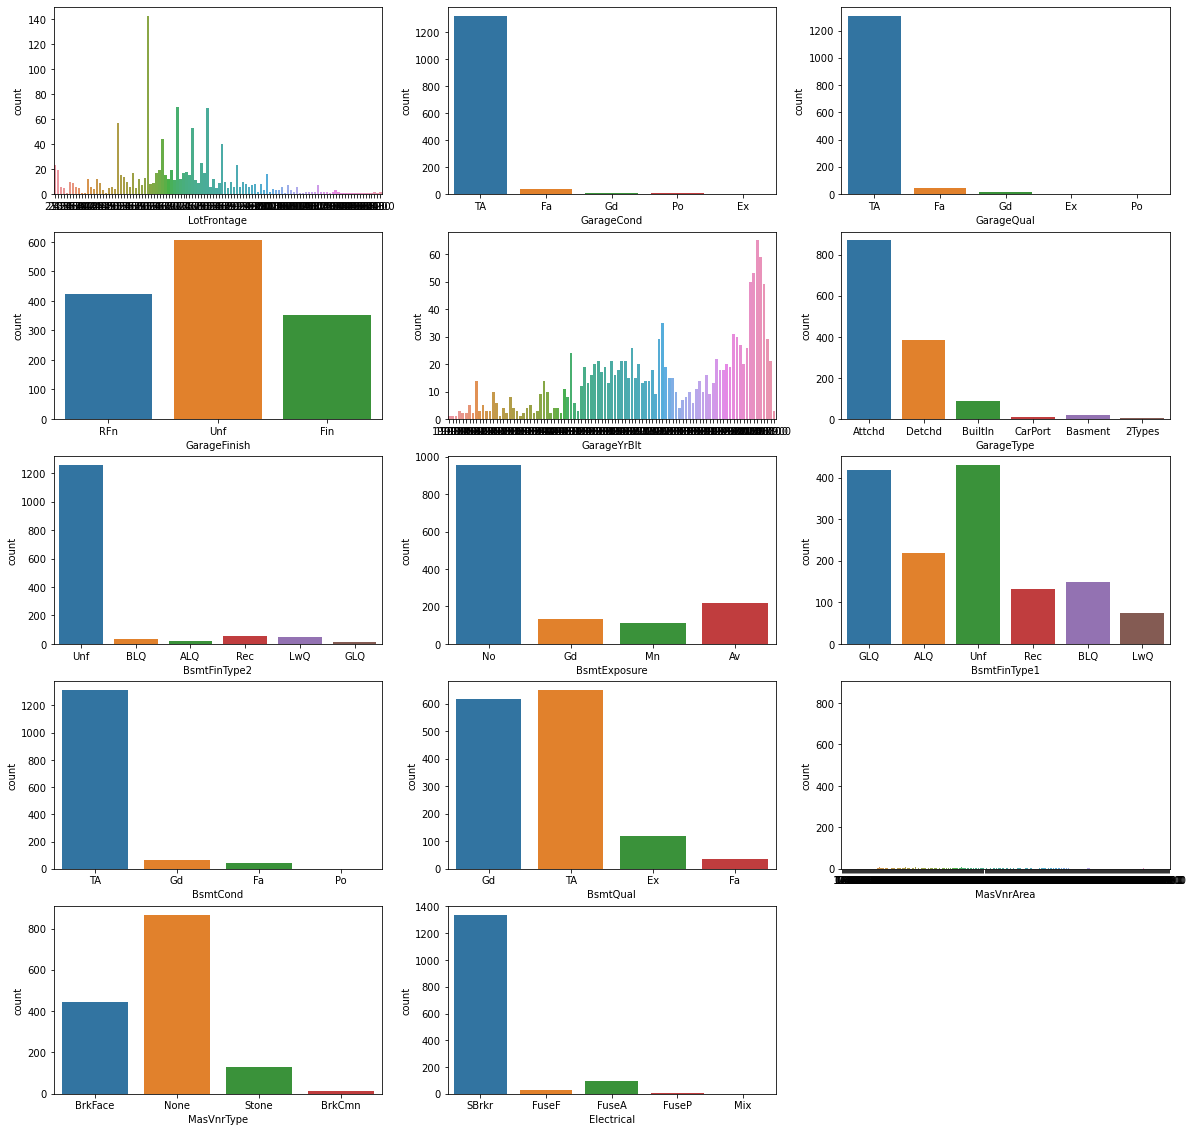

In [379]:
plt.figure(figsize=(20,20))
#sns.countplot(x='MasVnrArea',data=houseing_data)
cnt = 1
for col in missing_value.col:
    plt.subplot(5,3,cnt)
    sns.countplot(x=col,data=houseing_data)
    cnt = cnt+1


In [383]:
## Filling null values with mod
for col in missing_value.col:
    houseing_data[col].fillna(value=houseing_data[col].mode()[0],inplace=True)

In [382]:
#Calculating the null values in the dataframe
missing_value = houseing_data.isnull().sum()[houseing_data.isnull().sum()>0].sort_values(ascending=False)
missing_value = (missing_value/len(houseing_data))*100
#houseing_data.isnull().sum()[houseing_data.isnull().sum()>0].sort_values(ascending=False)
missing_value = missing_value.rename_axis('col').reset_index(name='prcnt')
missing_value

Empty DataFrame
Columns: [col, prcnt]
Index: []

## Data Understanding and Preparation

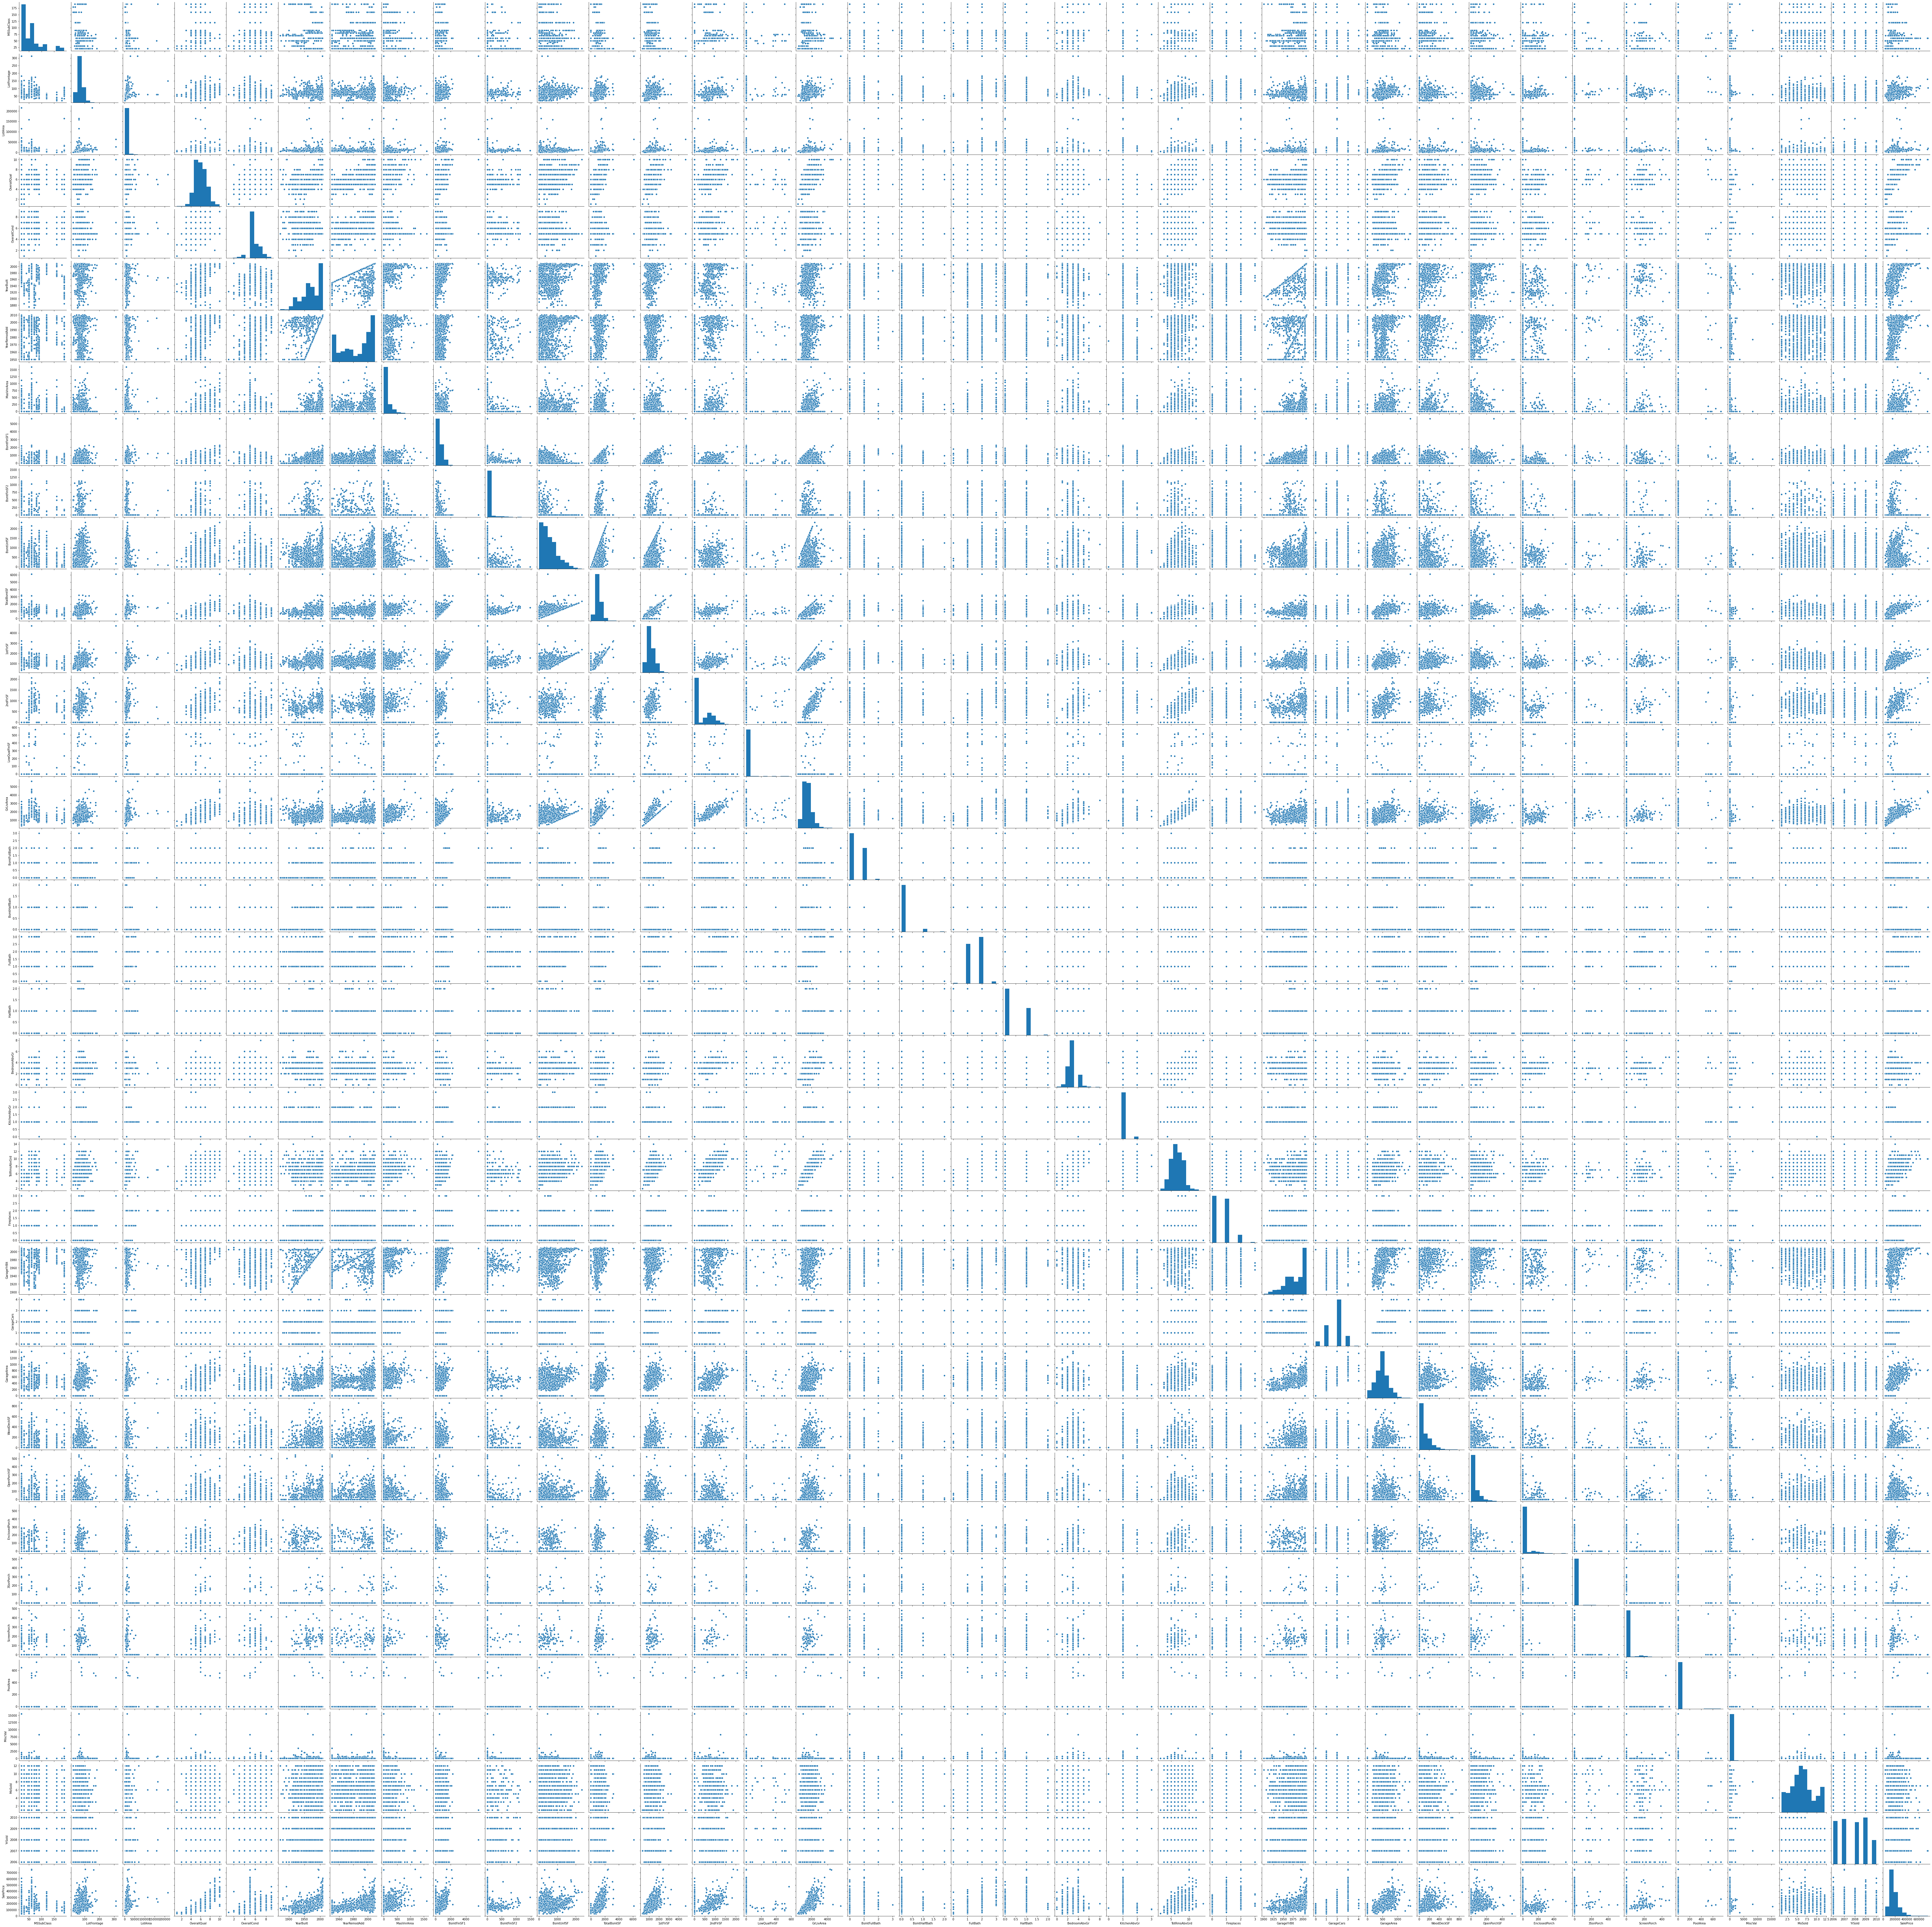

In [482]:
#Data Visualization using Pairplot
sns.pairplot(houseing_data)
plt.show()

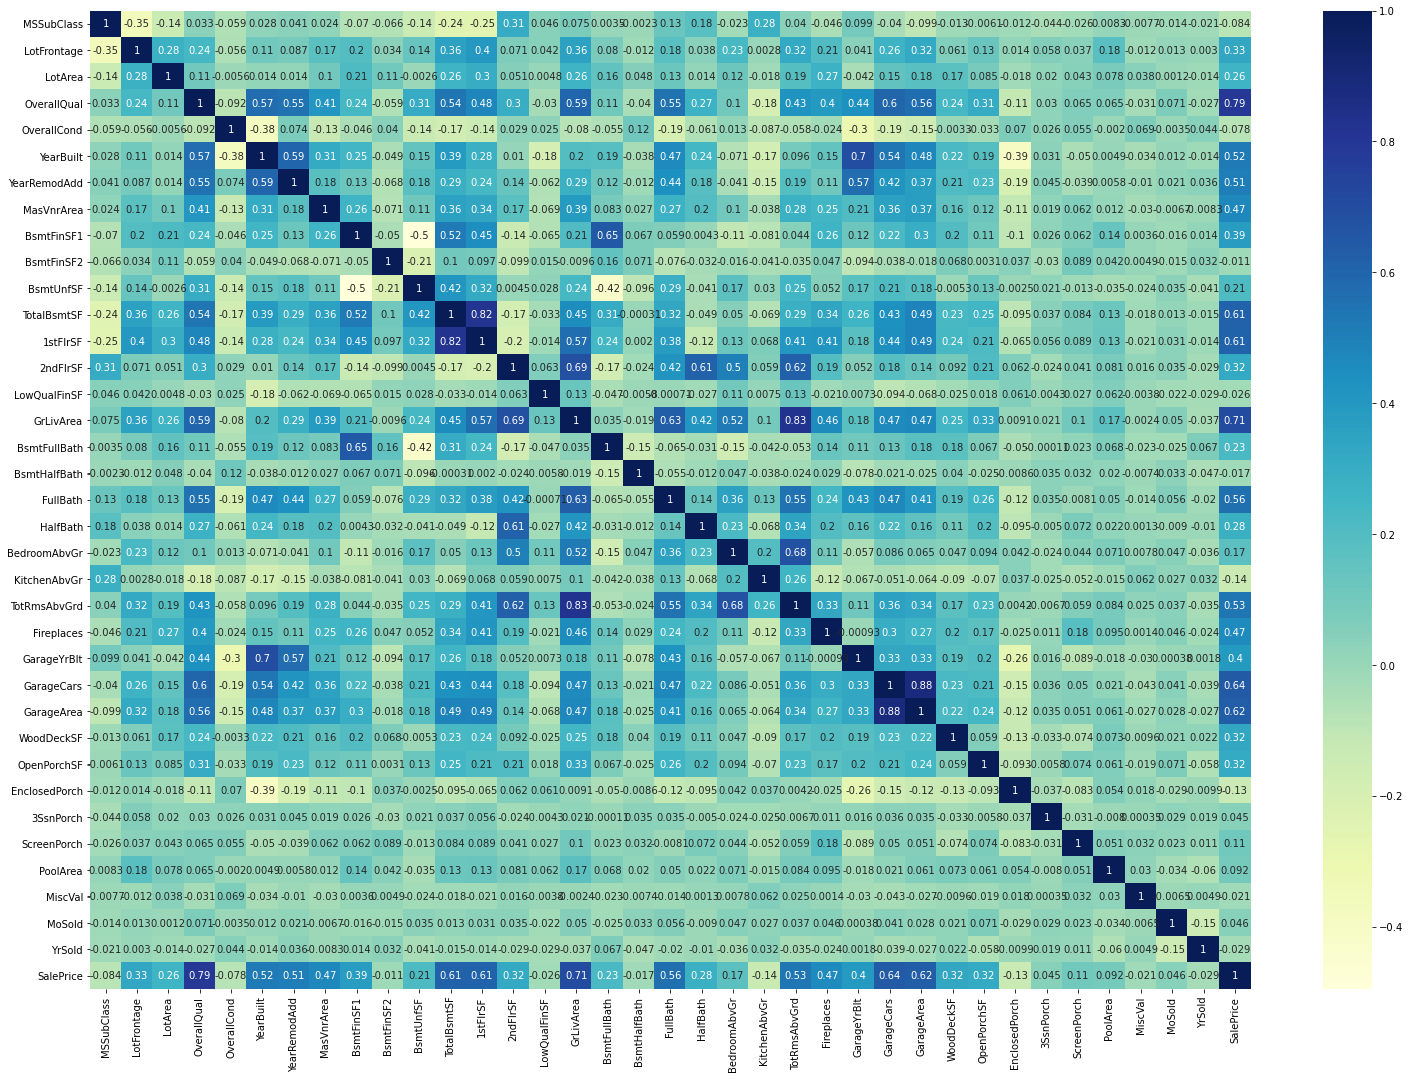

In [483]:
# Heatmap to find CoRelation among dependent and target variable(SalePrice)
plt.figure(figsize=(26,18))
sns.heatmap(houseing_data.corr(),annot=True,cmap="YlGnBu")
plt.show()

In [384]:
#Inserting a new varibale age=YrSold-YearBuilt and dropping YearBuilt & YrSold
houseing_data['HouseAge'] = houseing_data['YrSold'] - houseing_data['YearBuilt']
houseing_data = houseing_data.drop(['YearBuilt','YrSold'],axis=1)

In [385]:
Sale_Corr=houseing_data.corr()['SalePrice']
Sale_Corr.sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
GarageYrBlt      0.397778
BsmtFinSF1       0.386420
LotFrontage      0.329220
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
HouseAge        -0.523350
Name: SalePrice, dtype: float64

In [386]:
## Checking all the categorical varibles Value_count and dropping those have more than 98% in one category
for col in houseing_data.columns:
    if(isinstance(houseing_data[col].iloc[1], str)):
        tmp_series = houseing_data[col].value_counts().rename_axis('unique_values').reset_index(name='counts')
       # print(tmp_series)
        tmp_series['prcnt'] = (tmp_series.counts/sum(tmp_series.counts))*100
        tmp_series['unique_cnt'] = tmp_series.unique_values.nunique()
        if tmp_series.prcnt.max() > 98:
            #tmp_series = tmp_series[tmp_series.prcnt>=3]
            print(tmp_series)
            houseing_data.drop([col],axis=1)
            print(tmp_series)
    else:
        continue 

  unique_values  counts      prcnt  unique_cnt
0          Pave    1454  99.589041           2
1          Grvl       6   0.410959           2
  unique_values  counts      prcnt  unique_cnt
0          Pave    1454  99.589041           2
1          Grvl       6   0.410959           2
  unique_values  counts      prcnt  unique_cnt
0        AllPub    1459  99.931507           2
1        NoSeWa       1   0.068493           2
  unique_values  counts      prcnt  unique_cnt
0        AllPub    1459  99.931507           2
1        NoSeWa       1   0.068493           2
  unique_values  counts      prcnt  unique_cnt
0          Norm    1445  98.972603           8
1         Feedr       6   0.410959           8
2          PosN       2   0.136986           8
3          RRNn       2   0.136986           8
4        Artery       2   0.136986           8
5          RRAe       1   0.068493           8
6          RRAn       1   0.068493           8
7          PosA       1   0.068493           8
  unique_valu

In [387]:
## Creating Dummy Variables
for col in houseing_data.columns:
    if(isinstance(houseing_data[col].iloc[1], str)):
        houseing_data[col] = houseing_data[col].apply(lambda x:col+'_'+x)
        df_Dummy=pd.get_dummies(houseing_data[col],drop_first=True)
        houseing_data=pd.concat([houseing_data,df_Dummy],axis=1)
        houseing_data = houseing_data.drop([col],axis=1)

In [388]:
houseing_data.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearRemodAdd  \
Id                                                                             
1           60         65.0     8450            7            5          2003   
2           20         80.0     9600            6            8          1976   
3           60         68.0    11250            7            5          2002   
4           70         60.0     9550            7            5          1970   
5           60         84.0    14260            8            5          2000   

    MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLI  \
Id                                                 ...                   
1        196.0         706           0        150  ...               0   
2          0.0         978           0        284  ...               0   
3        162.0         486           0        434  ...               0   
4          0.0         216           0        540  ...               0   
5        350.0         655           0        490  ...               0   

    SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
Id                                                            
1                0             0             0            1   
2                0             0             0            1   
3                0             0             0            1   
4                0             0             0            1   
5                0             0             0            1   

    SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                      
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   
5                       0                     0                     0   

    SaleCondition_Normal  SaleCondition_Partial  
Id                                               
1                      1                      0  
2                      1                      0  
3                      1                      0  
4                      0                      0  
5                      1                      0  

[5 rows x 232 columns]

In [332]:
houseing_data.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    68.267123   10516.828082     6.099315     5.575342   
std      42.300571    22.356355    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    60.000000    7553.500000     5.000000     5.000000   
50%      50.000000    63.000000    9478.500000     6.000000     5.000000   
75%      70.000000    79.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count   1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean    1984.865753   103.117123   443.639726    46.549315   567.240411  ...   
std       20.645407   180.731373   456.098091   161.319273   441.866955  ...   
min     1950.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     1967.000000     0.000000     0.000000     0.000000   223.000000  ...   
50%     1994.000000     0.000000   383.500000     0.000000   477.500000  ...   
75%     2004.000000   164.250000   712.250000     0.000000   808.000000  ...   
max     2010.000000  1600.000000  5644.000000  1474.000000  2336.000000  ...   

       SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  \
count     1460.000000     1460.000000   1460.000000   1460.000000   
mean         0.003425        0.003425      0.083562      0.002055   
std          0.058440        0.058440      0.276824      0.045299   
min          0.000000        0.000000      0.000000      0.000000   
25%          0.000000        0.000000      0.000000      0.000000   
50%          0.000000        0.000000      0.000000      0.000000   
75%          0.000000        0.000000      0.000000      0.000000   
max          1.000000        1.000000      1.000000      1.000000   

       SaleType_WD  SaleCondition_AdjLand  SaleCondition_Alloca  \
count  1460.000000            1460.000000           1460.000000   
mean      0.867808               0.002740              0.008219   
std       0.338815               0.052289              0.090317   
min       0.000000               0.000000              0.000000   
25%       1.000000               0.000000              0.000000   
50%       1.000000               0.000000              0.000000   
75%       1.000000               0.000000              0.000000   
max       1.000000               1.000000              1.000000   

       SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
count           1460.000000           1460.000000            1460.000000  
mean               0.013699              0.820548               0.085616  
std                0.116277              0.383862               0.279893  
min                0.000000              0.000000               0.000000  
25%                0.000000              1.000000               0.000000  
50%                0.000000              1.000000               0.000000  
75%                0.000000              1.000000               0.000000  
max                1.000000              1.000000               1.000000  

[8 rows x 232 columns]

## Linear Regression with all variables

In [470]:
#Creating Training and Test DataSets

houseing_data_train,houseing_data_test=train_test_split(houseing_data,train_size=0.7,random_state=100)
print(houseing_data_train.shape)
print(houseing_data_test.shape)

(1021, 232)
(439, 232)


In [471]:
#Creating target variable (SalePrice) and dependent variable training sets

y_train = houseing_data_train.pop('SalePrice')
X_train = houseing_data_train

In [472]:
# Scalling the training set with min max scaller for the columns where max value is greater than 1

scale_var = []
scaler = MinMaxScaler()
for col in X_train.columns:
    if houseing_data[col].max()>1:
        scale_var.append(col)
X_train[scale_var] = scaler.fit_transform(X_train[scale_var])


<ipython-input-472-1f1445e2329c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[scale_var] = scaler.fit_transform(X_train[scale_var])
C:\Users\sarmaha\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [473]:
X_train.head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
Id                                                                  
319     0.235294     0.236301  0.039403     0.666667        0.500   
240     0.176471     0.106164  0.033981     0.555556        0.375   
987     0.176471     0.130137  0.017931     0.555556        0.875   
1417    1.000000     0.133562  0.046139     0.333333        0.625   
391     0.176471     0.099315  0.032409     0.444444        0.875   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
Id                                                                 ...   
319       0.716667        0.16    0.174876    0.000000   0.154110  ...   
240       0.000000        0.00    0.016655    0.000000   0.274401  ...   
987       0.883333        0.00    0.000000    0.000000   0.207620  ...   
1417      0.000000        0.00    0.000000    0.000000   0.332620  ...   
391       0.000000        0.00    0.042700    0.265265   0.098031  ...   

      SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
Id                                                                              
319                0               0             0             0            1   
240                0               0             0             0            1   
987                0               0             0             0            1   
1417               0               0             0             0            1   
391                0               0             0             0            1   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
319                       0                     0                     0   
240                       0                     0                     0   
987                       0                     0                     0   
1417                      0                     0                     0   
391                       0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
Id                                                 
319                      1                      0  
240                      1                      0  
987                      1                      0  
1417                     1                      0  
391                      1                      0  

[5 rows x 231 columns]

In [430]:
# VIF check for multicollinearity
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF',ascending = False)
vif

C:\Users\sarmaha\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\sarmaha\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Features   VIF
230  SaleCondition_Partial   inf
10             TotalBsmtSF   inf
118     Exterior1st_CBlock   inf
115    Exterior1st_AsphShn   inf
208          GarageQual_Fa   inf
..                     ...   ...
219           SaleType_Con  1.28
83         Condition1_RRNe  1.26
137      Exterior2nd_Other   NaN
152           ExterCond_Po   NaN
190         Electrical_Mix   NaN

[231 rows x 2 columns]

In [474]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.params

const                   -746027.771714
MSSubClass                -6724.682238
LotFrontage               23707.097146
LotArea                  153764.177855
OverallQual               55319.679948
                             ...      
SaleCondition_AdjLand     17264.767085
SaleCondition_Alloca      14990.845966
SaleCondition_Family       -157.872235
SaleCondition_Normal       4667.995294
SaleCondition_Partial      8694.248947
Length: 232, dtype: float64

In [475]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     65.84
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:51:51   Log-Likelihood:                -11452.
No. Observations:                1021   AIC:                         2.335e+04
Df Residuals:                     798   BIC:                         2.445e+04
Df Model:                         222                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -7.46e+05   6.65e+04    -11.225      0.000   -8.76e+05   -6.16e+05
MSSubClass            -6724.6822   1.57e+04     -0.428      0.668   -3.75e+04    2.41e+04
LotFrontage            2.371e+04    1.4e+04      1.693      0.091   -3776.911    5.12e+04
LotArea                1.538e+05   2.53e+04      6.069      0.000    1.04e+05    2.03e+05
OverallQual            5.532e+04   1.02e+04      5.417      0.000    3.53e+04    7.54e+04
OverallCond            4.528e+04   7955.985      5.692      0.000    2.97e+04    6.09e+04
YearRemodAdd           6741.2935   3673.504      1.835      0.067    -469.580     1.4e+04
MasVnrArea             3.396e+04   9468.353      3.586      0.000    1.54e+04    5.25e+04
BsmtFinSF1             1.125e+05   1.46e+04      7.687      0.000    8.38e+04    1.41e+05
BsmtFinSF2             1.618e+04   1.19e+04      1.362      0.173   -7134.183    3.95e+04
BsmtUnfSF              2433.8666   6343.928      0.384      0.701      -1e+04    1.49e+04
TotalBsmtSF            1.088e+05   1.46e+04      7.428      0.000       8e+04    1.38e+05
1stFlrSF               1.401e+05   1.45e+04      9.633      0.000    1.12e+05    1.69e+05
2ndFlrSF               1.049e+05   1.14e+04      9.173      0.000    8.24e+04    1.27e+05
LowQualFinSF          -1.216e+04   9711.512     -1.252      0.211   -3.12e+04    6902.696
GrLivArea              1.662e+05   1.16e+04     14.309      0.000    1.43e+05    1.89e+05
BsmtFullBath           3742.5560   6275.237      0.596      0.551   -8575.364    1.61e+04
BsmtHalfBath          -2349.4009   6569.559     -0.358      0.721   -1.52e+04    1.05e+04
FullBath               1619.7815   7219.793      0.224      0.823   -1.26e+04    1.58e+04
HalfBath              -7658.5486   4736.277     -1.617      0.106    -1.7e+04    1638.486
BedroomAbvGr          -2.915e+04   1.23e+04     -2.361      0.018   -5.34e+04   -4913.576
KitchenAbvGr          -2.972e+04   1.37e+04     -2.164      0.031   -5.67e+04   -2763.096
TotRmsAbvGrd          -5503.8594   1.19e+04     -0.463      0.644   -2.88e+04    1.78e+04
Fireplaces             3036.4406   4464.761      0.680      0.497   -5727.623    1.18e+04
GarageYrBlt            9158.3417   5909.223      1.550      0.122   -2441.116    2.08e+04
GarageCars             1.637e+04   1.01e+04      1.619      0.106   -3477.150    3.62e+04
GarageArea             7223.9172   1.26e+04      0.573      0.567   -1.75e+04     3.2e+04
WoodDeckSF             7261.7708   5481.799      1.325      0.186   -3498.679     1.8e+04
OpenPorchSF            1.099e+04   6696.384      1.641      0.101   -2155.830    2.41e+04
EnclosedPorch         -2731.4114   7564.621     -0.361      0.718   -1.76e+04    1.21e+04
3SsnPorch              1.288e+04   1.15e+04      1.116      0.265   -9781.308    3.55e+04
ScreenPorch            

### Applying the Model to Predict the Train data and Performing Residue Analysis

In [476]:
y_train_pred = lr_model.predict(X_train_sm)

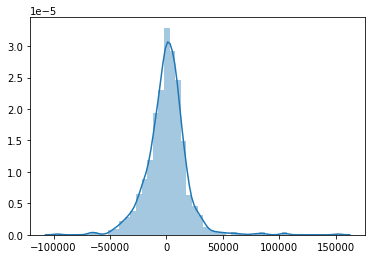

In [477]:
res = y_train - y_train_pred
sns.distplot(res)

### Applying the Model to Predict the Test Data and Performing Residue Analysis

In [478]:
#Creating target variable (cnt) and dependent variable test sets
y_test = houseing_data_test.pop('SalePrice')
X_test = houseing_data_test

In [479]:
#Dropping Date and Highly CoRelated columns from X_test and performing transform
#X_test = X_test.drop(['atemp','casual','registered','season','dteday','weathersit'],axis=1)
X_test[scale_var] = scaler.transform(X_test[scale_var])
X_test.describe()

<ipython-input-479-e3cc9c7ec4f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[scale_var] = scaler.transform(X_test[scale_var])
C:\Users\sarmaha\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


MSSubClass  LotFrontage     LotArea  OverallQual  OverallCond  \
count  439.000000   439.000000  439.000000   439.000000    439.00000   
mean     0.195498     0.163931    0.042580     0.568211      0.57033   
std      0.233458     0.076328    0.042978     0.149440      0.14508   
min      0.000000     0.000000   -0.000828     0.000000      0.12500   
25%      0.000000     0.133562    0.029293     0.444444      0.50000   
50%      0.176471     0.150685    0.036947     0.555556      0.50000   
75%      0.235294     0.202055    0.047823     0.666667      0.62500   
max      1.000000     1.000000    0.736888     1.000000      1.00000   

       YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2   BsmtUnfSF  ...  \
count    439.000000  439.000000  439.000000  439.000000  439.000000  ...   
mean       0.576500    0.062453    0.076739    0.025998    0.246305  ...   
std        0.346002    0.102809    0.077027    0.092564    0.182297  ...   
min        0.000000    0.000000    0.000000    0.000000    0.000000  ...   
25%        0.266667    0.000000    0.000000    0.000000    0.109161  ...   
50%        0.716667    0.000000    0.063962    0.000000    0.214041  ...   
75%        0.900000    0.108750    0.125177    0.000000    0.346318  ...   
max        1.000000    0.575625    0.387668    0.764586    0.828339  ...   

       SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  \
count      439.000000      439.000000    439.000000         439.0   
mean         0.004556        0.002278      0.095672           0.0   
std          0.067420        0.047727      0.294476           0.0   
min          0.000000        0.000000      0.000000           0.0   
25%          0.000000        0.000000      0.000000           0.0   
50%          0.000000        0.000000      0.000000           0.0   
75%          0.000000        0.000000      0.000000           0.0   
max          1.000000        1.000000      1.000000           0.0   

       SaleType_WD  SaleCondition_AdjLand  SaleCondition_Alloca  \
count   439.000000             439.000000            439.000000   
mean      0.861048               0.002278              0.009112   
std       0.346291               0.047727              0.095127   
min       0.000000               0.000000              0.000000   
25%       1.000000               0.000000              0.000000   
50%       1.000000               0.000000              0.000000   
75%       1.000000               0.000000              0.000000   
max       1.000000               1.000000              1.000000   

       SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
count            439.000000            439.000000             439.000000  
mean               0.013667              0.808656               0.102506  
std                0.116239              0.393808               0.303658  
min                0.000000              0.000000               0.000000  
25%                0.000000              1.000000               0.000000  
50%                0.000000              1.000000               0.000000  
75%                0.000000              1.000000               0.000000  
max                1.000000              1.000000               1.000000  

[8 rows x 231 columns]

In [480]:
#Adding constraint and Dropping all the columns as per training data
#X = X_test.drop(['hum','workingday','windspeed','weekday'],axis=1)
X_test_sm = sm.add_constant(X_test)
#X_test_sm = X_test_sm.drop(['hum','workingday','holiday','weekday'],axis=1)

In [481]:
# y_test Prediction
y_test_pred = lr_model.predict(X_test_sm)

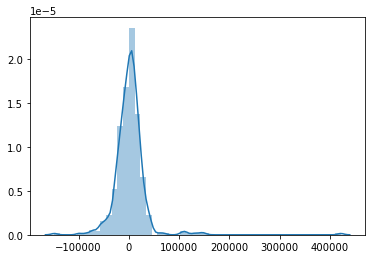

In [482]:
# Test data Residue Analysis 
res = y_test - y_test_pred
sns.distplot(res)

### r2_score value of test data

In [483]:
r2_score(y_true=y_test,y_pred=y_test_pred)

0.8260424014659629

### There is a 14% difference in the r2 value of test and training set, which suggests overfitting

### RFE to select top 20 variables
Recursive feature elimination

In [484]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [485]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [486]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 166),
 ('LotFrontage', True, 1),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', False, 9),
 ('YearRemodAdd', False, 63),
 ('MasVnrArea', False, 8),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', False, 27),
 ('BsmtUnfSF', False, 32),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', False, 10),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 86),
 ('BsmtHalfBath', False, 165),
 ('FullBath', False, 187),
 ('HalfBath', False, 108),
 ('BedroomAbvGr', True, 1),
 ('KitchenAbvGr', True, 1),
 ('TotRmsAbvGrd', False, 148),
 ('Fireplaces', False, 170),
 ('GarageYrBlt', False, 11),
 ('GarageCars', False, 15),
 ('GarageArea', False, 137),
 ('WoodDeckSF', False, 88),
 ('OpenPorchSF', False, 125),
 ('EnclosedPorch', False, 143),
 ('3SsnPorch', False, 67),
 ('ScreenPorch', False, 141),
 ('PoolArea', False, 7),
 ('MiscVal', False, 46),
 ('MoSold', False, 196),
 ('HouseAge', False, 95),
 ('MSZoning_FV', False, 39),
 ('M

In [487]:
col = X_train.columns[rfe.support_]
col

Index(['LotFrontage', 'LotArea', 'OverallQual', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'Condition2_PosN', 'RoofMatl_CompShg', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Heating_OthW',
       'Functional_Sev'],
      dtype='object')

In [488]:
X_train.columns[~rfe.support_]

Index(['MSSubClass', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF2',
       'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=211)

In [489]:
# Creating new datasets with rfe columns
X_train_rfe = X_train[col]
#y_train_rfe = y_train[col]
X_test_rfe = X_test[col]
#y_test_rfe = X_test[col]

In [490]:
import statsmodels.api as sm  
#X_train_rfe = sm.add_constant(X_train_rfe)

In [491]:
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     303.2
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:52:20   Log-Likelihood:                -11965.
No. Observations:                1021   AIC:                         2.397e+04
Df Residuals:                    1000   BIC:                         2.408e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -8.273e+05   3.55e+04  

In [492]:
X_test_rfe = sm.add_constant(X_test_rfe)
y_test_pred = lm.predict(X_test_rfe)
#lm = sm.OLS(y_test,X_test_rfe).fit()   # Running the linear model
r2_score(y_true=y_test,y_pred=y_test_pred)

0.7385977117176397

#### There is a 14% difference in the r2 value of test and training set, which suggests overfitting

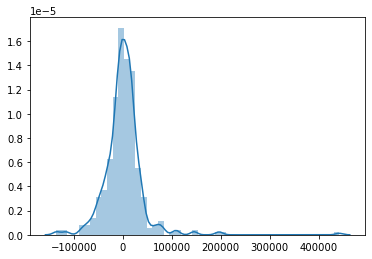

In [493]:
res = y_test - y_test_pred
sns.distplot(res)

In [494]:
# VIF check for multicollinearity
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF',ascending = False)
vif

Features      VIF
0              const  1426.71
8          GrLivArea   126.51
7           2ndFlrSF    87.48
6           1stFlrSF    74.45
12  RoofMatl_CompShg    23.85
16  RoofMatl_Tar&Grv     9.13
17  RoofMatl_WdShake     6.32
18  RoofMatl_WdShngl     6.14
5        TotalBsmtSF     4.17
13  RoofMatl_Membran     2.36
14    RoofMatl_Metal     2.34
15     RoofMatl_Roll     2.33
3        OverallQual     2.26
9       BedroomAbvGr     1.71
4         BsmtFinSF1     1.55
1        LotFrontage     1.45
10      KitchenAbvGr     1.25
2            LotArea     1.24
20    Functional_Sev     1.21
11   Condition2_PosN     1.07
19      Heating_OthW     1.03

In [495]:
y_pred_train = lm.predict(X_train_rfe)
y_pred_test = lm.predict(X_test_rfe)

metric=[]
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train-y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test-y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train,y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test,y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.8584498050449363
0.7385977117176397
903353032206.5623
738651017702.968
884772803.3364959
1682576350.120656


## Ridge Regression

In [498]:
# Applying Ridge Regression with varying the hyperparameter 'lambda'

params = {'alpha': [0.0001, 0.001, 0.01,0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1, 10,20,50, 100,500, 1000]} # Higher the value of lambda, 
                                                  # more the regularization
ridge = Ridge()
          
# Cross Validation
folds = 5
model_cv = GridSearchCV(estimator=ridge,
                       param_grid=params,
                       scoring= 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score=True,
                       verbose=1)
model_cv.fit(X_train_rfe,y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [499]:
print(model_cv.best_params_)

{'alpha': 0.1}


In [500]:
alpha=0.1
ridge=Ridge(alpha=alpha)
ridge.fit(X_train_rfe,y_train)
print(ridge.coef_)

[      0.           54892.94929994   78807.90984241  214073.94108131
  121416.12203507  103412.03888134  269071.7138427   104833.54580343
   70307.96958812  -63153.24345078  -52306.45448221 -375215.50441705
  406770.6135507   392862.72849542  378330.81491806  363938.42806998
  402242.52895862  360661.06837037  464999.2967055  -111648.82386904
  -91272.98831992]


In [501]:
y_pred_train = ridge.predict(X_train_rfe)
y_pred_test = ridge.predict(X_test_rfe)

metric2=[]
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train-y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test-y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train,y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test,y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8399411032622051
0.7565289850919844
1021472911044.915
687982167733.4412
1000463184.177194
1567157557.4793649


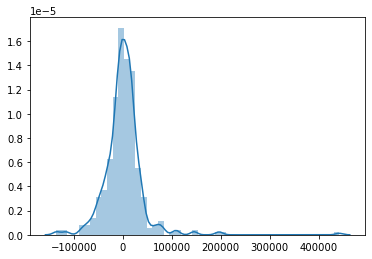

In [502]:
res = y_test - y_test_pred
sns.distplot(res)

## Lasso Regression

In [503]:
## Laso Regression
lasso = Lasso()
          
# Cross Validation

model_cv = GridSearchCV(estimator=lasso,
                       param_grid=params,
                       scoring= 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score=True,
                       verbose=1)
model_cv.fit(X_train_rfe,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373648813761.2494, tolerance: 530441932.6693996
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338110597611.4231, tolerance: 485755859.6182948
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370964377191.82166, tolerance: 516664170.66077894
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Ana

C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10632073926.120972, tolerance: 530441932.6693996
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 817899169.9884033, tolerance: 516664170.66077894
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2592748613.5474854, tolerance: 487686208.9717251
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [504]:
print(model_cv.best_params_)

{'alpha': 20}


In [505]:
alpha=20
lasso=Lasso(alpha=alpha)
lasso.fit(X_train_rfe,y_train)
print(lasso.coef_)

[      0.           69347.8321882    69263.48366078  204940.91402855
  134902.15849272  120433.50302235  336463.80324354  139215.97005544
       0.          -68214.97845112  -52985.48010286 -408191.77311465
  582329.74131662  588795.41672911  571345.87121716  553307.48627893
  578423.96686331  538244.62541269  643803.58785276  -97262.05916798
  -81734.64268368]


In [506]:
y_pred_train = lasso.predict(X_train_rfe)
y_pred_test = lasso.predict(X_test_rfe)

metric3=[]
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train-y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test-y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train,y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test,y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8528084345647584
0.7500719317251996
939355449092.5798
706228025763.521
920034719.9731438
1608719876.4544897


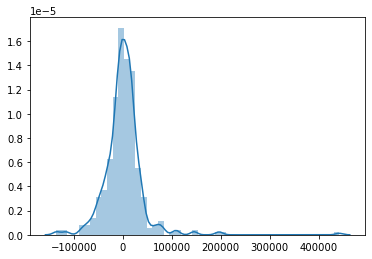

In [507]:
res = y_test - y_test_pred
sns.distplot(res)

# Creating a table to show Coefficient matric of 3 regression models

In [508]:


lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)','MSE (Train)','MSE (Test)'],'Linear Regression': metric}

lr_metric = pd.DataFrame(lr_table,columns = ['Metric', 'Linear Regression'])


rg_metric = pd.Series(metric2, name='Ridge Regression')
ls_metric = pd.Series(metric3, name='Lasso Regression')

final_matric = pd.concat([lr_metric,rg_metric,ls_metric],axis = 1)
final_matric


Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)       8.584498e-01      8.399411e-01      8.528084e-01
1   R2 Score (Test)       7.385977e-01      7.565290e-01      7.500719e-01
2       RSS (Train)       9.033530e+11      1.021473e+12      9.393554e+11
3        RSS (Test)       7.386510e+11      6.879822e+11      7.062280e+11
4       MSE (Train)       2.974513e+04      3.163010e+04      3.033207e+04
5        MSE (Test)       4.101922e+04      3.958734e+04      4.010885e+04

### Showing all the parameter values with their corresponidn co efficients showing significance

In [509]:
betas = pd.DataFrame(index=X_train_rfe.columns)
betas.rows = X_train_rfe.columns
#betas['Linear']= lm.coef_
betas['Ridge']=ridge.coef_
betas['Lasso']=lasso.coef_
#lm.coef_
betas

<ipython-input-509-70850741b963>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas.rows = X_train_rfe.columns


Ridge          Lasso
const                  0.000000       0.000000
LotFrontage        54892.949300   69347.832188
LotArea            78807.909842   69263.483661
OverallQual       214073.941081  204940.914029
BsmtFinSF1        121416.122035  134902.158493
TotalBsmtSF       103412.038881  120433.503022
1stFlrSF          269071.713843  336463.803244
2ndFlrSF          104833.545803  139215.970055
GrLivArea          70307.969588       0.000000
BedroomAbvGr      -63153.243451  -68214.978451
KitchenAbvGr      -52306.454482  -52985.480103
Condition2_PosN  -375215.504417 -408191.773115
RoofMatl_CompShg  406770.613551  582329.741317
RoofMatl_Membran  392862.728495  588795.416729
RoofMatl_Metal    378330.814918  571345.871217
RoofMatl_Roll     363938.428070  553307.486279
RoofMatl_Tar&Grv  402242.528959  578423.966863
RoofMatl_WdShake  360661.068370  538244.625413
RoofMatl_WdShngl  464999.296706  643803.587853
Heating_OthW     -111648.823869  -97262.059168
Functional_Sev    -91272.988320  -81734.642684

# Final Model

After performing Linear, Ridge and Lasso regression below are the conclusions for the final model

-  Performed Liner Regression with all the variables after data cleaning. There is a 14 % difference in Train and Test  Prediction
-  RFE to select best 20 features. After RFE Train and Test R2 values are at 86 and 74 %
-  On RFE data both Lasso and Rigde regression is performed and found that Ridge is the most effective Regression model in this case with alpha 0.1. Below is the list of Paramaters with Co-efficients

                   Ridge	    Lasso
     const	            0	            0 <br /> 
    LotFrontage	        54892.9493	69347.83219 <br /> 
    LotArea	            78807.90984	69263.48366 <br /> 
    OverallQual	        214073.9411	204940.914 <br /> 
    BsmtFinSF1	        121416.122	134902.1585 <br /> 
    TotalBsmtSF	        103412.0389	120433.503 <br /> 
    1stFlrSF	        269071.7138	336463.8032 <br /> 
    2ndFlrSF	        104833.5458	139215.9701 <br /> 
    GrLivArea	        70307.96959	0 <br /> 
    BedroomAbvGr	   -63153.24345	-68214.97845 <br /> 
    KitchenAbvGr	   -52306.45448	-52985.4801 <br /> 
    Condition2_PosN	   -375215.5044	-408191.7731 <br /> 
    RoofMatl_CompShg	406770.6136	582329.7413 <br /> 
    RoofMatl_Membran	392862.7285	588795.4167 <br /> 
    RoofMatl_Metal	    378330.8149	571345.8712 <br /> 
    RoofMatl_Roll	    363938.4281	553307.4863 <br /> 
    RoofMatl_Tar&Grv	402242.529	578423.9669 <br /> 
    RoofMatl_WdShake	360661.0684	538244.6254 <br /> 
    RoofMatl_WdShngl	464999.2967	643803.5879 <br /> 
    Heating_OthW	   -111648.8239	-97262.05917 <br /> 
    Functional_Sev	   -91272.98832	-81734.64268
     

## Ridge Regression After doubling lamda value

In [510]:
# Applying Ridge Regression with varying the hyperparameter 'lambda'

params = {'alpha': [0.0001, 0.001, 0.01,0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1, 10,20,50, 100,500, 1000]} # Higher the value of lambda, 
                                                  # more the regularization
ridge = Ridge()
          
# Cross Validation
folds = 5
model_cv = GridSearchCV(estimator=ridge,
                       param_grid=params,
                       scoring= 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score=True,
                       verbose=1)
model_cv.fit(X_train_rfe,y_train)

alpha=0.2
ridge=Ridge(alpha=alpha)
ridge.fit(X_train_rfe,y_train)
print(ridge.coef_)


y_pred_train = ridge.predict(X_train_rfe)
y_pred_test = ridge.predict(X_test_rfe)

metric2=[]
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train-y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test-y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train,y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test,y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[      0.           43926.55096386   78954.90731223  221297.75736123
  110814.48931214   90017.15854708  229084.83297469   83298.80953934
  107466.60233508  -55847.64392188  -50941.81346966 -331193.30405565
  278949.37027873  253614.69889544  240963.59530634  228159.17985874
  271662.68958198  232527.22396648  336191.81038479 -105096.85214592
  -79886.05495603]
0.8252957825783984
0.764022720337733
1114937246092.663
666806931655.5928
1092005138.1906593
1518922395.5708263


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


## Ridge Lasso After doubling lamda value

In [511]:
## Laso Regression
lasso = Lasso()
          
# Cross Validation

model_cv = GridSearchCV(estimator=lasso,
                       param_grid=params,
                       scoring= 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score=True,
                       verbose=1)
model_cv.fit(X_train_rfe,y_train)



alpha=40
lasso=Lasso(alpha=alpha)
lasso.fit(X_train_rfe,y_train)
print(lasso.coef_)


y_pred_train = lasso.predict(X_train_rfe)
y_pred_test = lasso.predict(X_test_rfe)

metric3=[]
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train-y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test-y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train,y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test,y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373648813761.2494, tolerance: 530441932.6693996
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338110597611.4231, tolerance: 485755859.6182948
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370964377191.82166, tolerance: 516664170.66077894
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Ana

C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 817899169.9884033, tolerance: 516664170.66077894
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2592748613.5474854, tolerance: 487686208.9717251
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6501095312.218262, tolerance: 530441932.6693996
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

[      0.           49578.38166168   66846.03401664  217489.87067699
  118885.33863842   91532.50032256  328870.44310267  128106.9689456
       0.          -54737.06406502  -50524.85105396 -363821.87098975
  379508.91653149  366043.92237574  349840.73084994  332313.74571244
  369703.83371599  332973.98275518  442604.53688366  -80489.43013157
  -53060.85263765]
0.8368429672871656
0.7574745688282885
1041244770265.0923
685310207997.6111
1019828374.4026369
1561071088.832827


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


In [512]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)','MSE (Train)','MSE (Test)'],'Linear Regression': metric}

lr_metric = pd.DataFrame(lr_table,columns = ['Metric', 'Linear Regression'])


rg_metric = pd.Series(metric2, name='Ridge Regression')
ls_metric = pd.Series(metric3, name='Lasso Regression')

final_matric = pd.concat([lr_metric,rg_metric,ls_metric],axis = 1)
final_matric


Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)       8.584498e-01      8.252958e-01      8.368430e-01
1   R2 Score (Test)       7.385977e-01      7.640227e-01      7.574746e-01
2       RSS (Train)       9.033530e+11      1.114937e+12      1.041245e+12
3        RSS (Test)       7.386510e+11      6.668069e+11      6.853102e+11
4       MSE (Train)       2.974513e+04      3.304550e+04      3.193475e+04
5        MSE (Test)       4.101922e+04      3.897335e+04      3.951039e+04

In [513]:
betas = pd.DataFrame(index=X_train_rfe.columns)
betas.rows = X_train_rfe.columns
#betas['Linear']= lm.coef_
betas['Ridge']=ridge.coef_
betas['Lasso']=lasso.coef_
#lm.coef_
betas

<ipython-input-513-70850741b963>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas.rows = X_train_rfe.columns


Ridge          Lasso
const                  0.000000       0.000000
LotFrontage        43926.550964   49578.381662
LotArea            78954.907312   66846.034017
OverallQual       221297.757361  217489.870677
BsmtFinSF1        110814.489312  118885.338638
TotalBsmtSF        90017.158547   91532.500323
1stFlrSF          229084.832975  328870.443103
2ndFlrSF           83298.809539  128106.968946
GrLivArea         107466.602335       0.000000
BedroomAbvGr      -55847.643922  -54737.064065
KitchenAbvGr      -50941.813470  -50524.851054
Condition2_PosN  -331193.304056 -363821.870990
RoofMatl_CompShg  278949.370279  379508.916531
RoofMatl_Membran  253614.698895  366043.922376
RoofMatl_Metal    240963.595306  349840.730850
RoofMatl_Roll     228159.179859  332313.745712
RoofMatl_Tar&Grv  271662.689582  369703.833716
RoofMatl_WdShake  232527.223966  332973.982755
RoofMatl_WdShngl  336191.810385  442604.536884
Heating_OthW     -105096.852146  -80489.430132
Functional_Sev    -79886.054956  -53060.852638

In [515]:
##Removing 5 most significant columns
X_train_rfe = X_train_rfe.drop(['RoofMatl_WdShngl','RoofMatl_Membran','RoofMatl_CompShg','RoofMatl_Tar&Grv','RoofMatl_Metal','RoofMatl_Roll'],axis=1)
X_test_rfe = X_test_rfe.drop(['RoofMatl_WdShngl','RoofMatl_Membran','RoofMatl_CompShg','RoofMatl_Tar&Grv','RoofMatl_Metal','RoofMatl_Roll'],axis=1)


In [516]:
lasso = Lasso()
          
# Cross Validation

model_cv = GridSearchCV(estimator=lasso,
                       param_grid=params,
                       scoring= 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score=True,
                       verbose=1)
model_cv.fit(X_train_rfe,y_train)

print(model_cv.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607810397732.8285, tolerance: 530441932.6693996
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344662280798.85364, tolerance: 485755859.6182948
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600424685804.6862, tolerance: 516664170.66077894
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Ana

C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13643523373.638184, tolerance: 530441932.6693996
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1548240698.189209, tolerance: 516664170.66077894
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1792911738.7749023, tolerance: 487686208.9717251
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarmaha\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

{'alpha': 0.8}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


In [517]:
alpha=0.8
lasso=Lasso(alpha=alpha)
lasso.fit(X_train_rfe,y_train)
print(lasso.coef_)


y_pred_train = lasso.predict(X_train_rfe)
y_pred_test = lasso.predict(X_test_rfe)

metric3=[]
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train-y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test-y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train,y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test,y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)


[      0.           13332.26064058   94577.68387541  233281.24836358
   91429.32366247   49700.34361856  436556.8527417   169973.85478796
 -124824.20638368  -47884.44104256  -54581.0516899  -381412.49908105
  -36348.38870528 -121584.15597497 -104635.6628854 ]
0.78276663684483
0.7444067119186151
1386352151368.9873
722236379795.6958
1357837562.5553255
1645185375.3888288


In [519]:
betas = pd.DataFrame(index=X_train_rfe.columns)
betas.rows = X_train_rfe.columns
#betas['Linear']= lm.coef_
#betas['Ridge']=ridge.coef_
betas['Lasso']=lasso.coef_
#lm.coef_
betas

<ipython-input-519-e9050daa3fa2>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas.rows = X_train_rfe.columns


Lasso
const                  0.000000
LotFrontage        13332.260641
LotArea            94577.683875
OverallQual       233281.248364
BsmtFinSF1         91429.323662
TotalBsmtSF        49700.343619
1stFlrSF          436556.852742
2ndFlrSF          169973.854788
GrLivArea        -124824.206384
BedroomAbvGr      -47884.441043
KitchenAbvGr      -54581.051690
Condition2_PosN  -381412.499081
RoofMatl_WdShake  -36348.388705
Heating_OthW     -121584.155975
Functional_Sev   -104635.662885

In [520]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)','MSE (Train)','MSE (Test)'],'Linear Regression': metric}

lr_metric = pd.DataFrame(lr_table,columns = ['Metric', 'Linear Regression'])


#rg_metric = pd.Series(metric2, name='Ridge Regression')
ls_metric = pd.Series(metric3, name='Lasso Regression')

final_matric = pd.concat([lr_metric,ls_metric],axis = 1)
final_matric

Metric  Linear Regression  Lasso Regression
0  R2 Score (Train)       8.584498e-01      7.827666e-01
1   R2 Score (Test)       7.385977e-01      7.444067e-01
2       RSS (Train)       9.033530e+11      1.386352e+12
3        RSS (Test)       7.386510e+11      7.222364e+11
4       MSE (Train)       2.974513e+04      3.684885e+04
5        MSE (Test)       4.101922e+04      4.056088e+04